<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spectral-estimation" data-toc-modified-id="Spectral-estimation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spectral estimation</a></span><ul class="toc-item"><li><span><a href="#Optimal-MaxCut-though-complete-enumeration" data-toc-modified-id="Optimal-MaxCut-though-complete-enumeration-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Optimal MaxCut though complete enumeration</a></span></li></ul></li></ul></div>

In [3]:
import numpy as np
import networkx as nx
import qtensor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

In [2]:
B = qtensor.toolbox.bethe_graph(p=5, degree=3)

## Spectral estimation

Use second-smallest eigenvector of a laplacian matrix multiplied by number of edges


https://arxiv.org/pdf/0806.1978.pdf

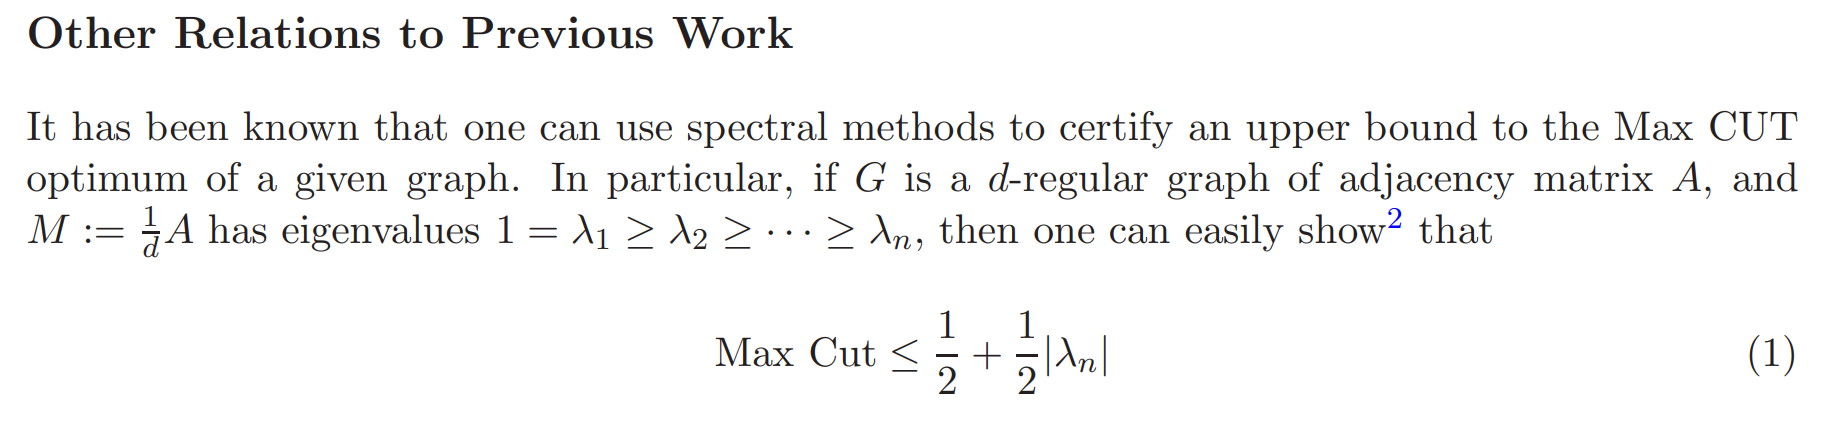

In [118]:
def spectral_bound(G):
    """ Returns a spectral upper bound to MaxCut on graph G, fraction of edges. """
    def is_regular(G):
        degrees = np.array(G.degree)[:, 1]
        return not bool(np.sum(degrees - degrees.min()))
    if not is_regular(G):
        raise ValueError('Graph should be regular')
    A = nx.adjacency_matrix(G)
    d = G.degree(list(G.nodes())[0])
    M = 1/d*A.toarray()
    spectrum = np.linalg.eigvals(M)
    spectrum.sort()
    return 1/2 + 1/2*np.abs(spectrum[0])
    

In [119]:
G = nx.random_regular_graph(d=3, n=10, seed=10)

In [120]:
spectral_bound(G)

0.9093654661820856

### Optimal MaxCut though complete enumeration

In [128]:
def maxcut_optimal(G, print_stats=False):
    '''
    Computes the MAXCUT partition for a graph G
    
    G - networkX graph
    
    returns:
        number of edges cut
        the partition (as signs +/-1)
    
    '''
    import time
    # There is a Z2 symmetry which takes Z -> -Z. We can break this symmetry and
    #  gain a factor of 2 speedup by fixing the last bit to be in the +1 sector
    Nbits = len(G.nodes) - 1
    
    '''
    Generate an indexing of the Hilbert space in the Z basis.
    '''
    # Index 0 is the all up state
    # Index -1 is the all down state
    # The least significant bit is the lefthand index in the bitarray (eg qubit 0)
    def index2state(index):
        return np.array([1 - 2*((index>>i)%2) for i in range(Nbits)])
    def state2index(state):
        return np.dot((1 - state)//2,2**np.arange(Nbits))
    
    t1 = time.time()
    
    indexing = np.arange(2**Nbits) # Making this not memory bound would be to iterate over chunks
    bits = [(1 - 2*((indexing>>i)%2)).astype(np.int8) for i in range(Nbits)]
    
    t2 = time.time()
    '''
    Generate the cost function by summing over all clauses
    '''
    # Note that because we have broken Z2 symmetry by fixing the sign of the last
    #  bit there needs to be a conditional on the summation (eg it is always 1)
    #  ZZ is a product of two Z expectation values.
    # In this way, any size clauses can be found (eg ZZZ is bits[]*bits[]*bits[])
    ZZcost = np.zeros(2**Nbits)
    for edge in G.edges:
        edge = np.sort(edge)
        if edge[1]==Nbits:
            ZZcost += (1 - bits[edge[0]])//2
        else:
            ZZcost += (1 - bits[edge[0]]*bits[edge[1]])//2
    
    t3 = time.time()
    # MAXCUT normally wants the max cut (huh.)
    maxdex = np.argmax(ZZcost)
    maxstate = index2state(maxdex)
    t4 = time.time()
    
    if print_stats:
        print('Time to generate basis: {:0.4f}'.format(t2-t1))
        print('Time to generate cost:  {:0.4f}'.format(t3-t2))
        print('Time to find maximum:   {:0.4f}'.format(t4-t3))
        print('Total Time:             {:0.4f}'.format(t4-t1))
        
    return ZZcost[maxdex],maxstate


In [129]:
cost, parts = maxcut_optimal(G, print_stats=True)
opt_fraction = cost/G.number_of_edges()
opt_fraction

Time to generate basis: 0.0175
Time to generate cost:  0.0214
Time to find maximum:   0.0002
Total Time:             0.0391


0.8518518518518519

In [133]:
def optimal_fraction(G):
    cost, _ = maxcut_optimal(G)
    opt_fraction = cost/G.number_of_edges()
    return opt_fraction


In [159]:
from cartesian_explorer import Explorer
ex = Explorer()

In [160]:
ex.add_function(provides='G', requires=('d','n'))(nx.random_regular_graph)

ex.provider(optimal_fraction)
ex.provider(spectral_bound)

<function __main__.spectral_bound(G)>

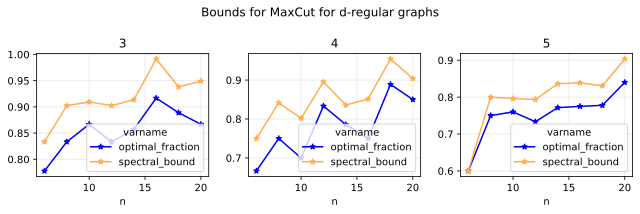

In [178]:
fig = ex.plot(ex.get_variable,
              plot_kwargs=dict(marker='*'),
              d=[3,4,5],
              varname=('optimal_fraction', 'spectral_bound'), 
              n=range(6, 22, 2),
              seed=[10]
             )

plt.suptitle('Bounds for MaxCut for d-regular graphs')
plt.gcf().set_size_inches((9, 3))
plt.tight_layout()